In [1]:
from google.cloud import bigquery
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import datetime 
import requests
import json
import tensorflow as tf
import plotly.graph_objects as go
import plotly.express as px

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
# nvcc --version  ###CUDA version

import pathlib
import shutil
from numpy.random import seed
seed(2)
tf.random.set_seed(2)
from math import sqrt

random_state = 42
# import mlflow
# exp_id = 'weather_dataset'
# mlflow.set_experiment(exp_id)
# mlflow.set_tracking_uri('file:///C:/Users/gabri/VSCode%20Projects/Weather%20Prediction/mlruns')
# mlflow.autolog()
# mlflow.log_param('random_state', random_state)
# export MLFLOW_TRACKING_URI=http://192.168.0.1:5000


In [2]:
# 1) define training, testing and prediction daterange 
# 2) define parameters, feature engineering and transformations, create dataframe 
# 3) convert to numpy and reshape 
# 4) define train, test and val split
# 5) normalize
# 6) define model and log in MLFlow
# 7) model training

In [3]:
# project details and gcp connection
project_id = "galvanic-smoke-394310"
key_path = r'C:\Users\gabri\GCP\galvanic-smoke-394310-c595ae82c676_bigquery.json'
client = bigquery.Client.from_service_account_json(key_path)

In [4]:
# get data query
# training_start = '2021-08-01'
# training_end = '2021-08-12'
training_start = '2021-08-01 00:00:00'  # Specify the start time with hours, minutes, and seconds
training_end = '2022-08-11 23:01:00'  # Specify the end time with hours, minutes, and seconds

location_1 = 'City of London'
location_2 = 'Cockfosters'

# date_obj_start = datetime.datetime.strptime(training_start, '%Y-%m-%d')
# date_obj_end = datetime.datetime.strptime(training_end, '%Y-%m-%d')
date_obj_start = datetime.datetime.strptime(training_start, '%Y-%m-%d %H:%M:%S')  # Include '%H:%M:%S'
date_obj_end = datetime.datetime.strptime(training_end, '%Y-%m-%d %H:%M:%S')  # Include '%H:%M:%S'
unix_start = int(date_obj_start.timestamp())
unix_end = int(date_obj_end.timestamp())


query = f"""
select dt, temp - 273.15 as temp, pressure, humidity
from galvanic-smoke-394310.weather_training.weather_city_of_london_training
where dt > {unix_start} and dt < {unix_end}
order by dt
"""
query_job = client.query(query)
df_filtered_cl = query_job.to_dataframe()

query = f"""
select dt, temp - 273.15 as temp, pressure, humidity
from galvanic-smoke-394310.weather_training.weather_cockfosters_historical
where dt > {unix_start} and dt < {unix_end}
order by dt
"""
query_job = client.query(query)
df_filtered_cf = query_job.to_dataframe()
print(f'Gets data from {training_start} to {training_end} from {location_1} and {location_2} and merges the two tables')

Gets data from 2021-08-01 00:00:00 to 2022-08-11 23:01:00 from City of London and Cockfosters and merges the two tables


In [5]:
# rename columns to distinguish them by location, each location is treated as a different feature
df_filtered_cl.rename(columns={'dt': 'dt_cl', 'temp': 'cl_temp', 'pressure': 'cl_pressure', 'humidity': 'cl_humidity'}, inplace=True)
df_filtered_cf.rename(columns={'dt': 'dt_cf', 'temp': 'cf_temp', 'pressure': 'cf_pressure', 'humidity': 'cf_humidity'}, inplace=True)

# merge tables / dataframes
merged_df = pd.merge(df_filtered_cl, df_filtered_cf, how='left', left_on='dt_cl', right_on='dt_cf')

# copy dataframe

# filter and copy dataframe columns, select one timestamp and rename 
columns_to_keep = ['dt_cl', 'cl_temp']
features = ['cl_temp']
final_df = merged_df[columns_to_keep].copy()
final_df.rename(columns={'dt_cl': 'dt'}, inplace=True)

print(f"Timestamp column name changed to 'dt'")
print(f'Features selected: {columns_to_keep}')
print(final_df.head(1))

Timestamp column name changed to 'dt'
Features selected: ['dt_cl', 'cl_temp']
           dt  cl_temp
0  1627776000    15.49


In [6]:
# create arrays from dataframe columns, convert Unix timestamp to UTC datetime

index_list=[]
timestamp_list=[]
for idx, timestamp in enumerate(final_df['dt'].to_numpy()):
    index_list.append(idx) 
    timestamp_list.append(timestamp)

datetime_list = [datetime.datetime.utcfromtimestamp(event) for event in timestamp_list]
final_df = final_df.drop(columns='dt', axis=0)
dataset_length = len(index_list)
print(f'Number of indices: {dataset_length}')
print('Converted dataframe columns to lists')

Number of indices: 9084
Converted dataframe columns to lists


In [7]:
start_date = datetime.datetime.utcfromtimestamp(timestamp_list[0])
end_date = datetime.datetime.utcfromtimestamp(timestamp_list[-1])

context_hours = 24
prediction_length = 24
eliminated_timesteps = context_hours - 1

print(f'Dataset starts on {start_date}')
print(f'Dataset ends on {end_date}')
print(f'Original length of dataset: {dataset_length} hours')


print(f'Length of context: {context_hours} hours')
print(f'Number of hours to predict predict: {prediction_length} hours')
print(f'Given temperature from the last {context_hours} hours, we want to predict temperature over the next {prediction_length} hours')
print(f'In order to create windows, we lose {eliminated_timesteps} hours to create the first window')

new_dataset_length = dataset_length - eliminated_timesteps
window_count = new_dataset_length
print(f'Number of datapoints for training, validation and testing: {new_dataset_length} hours')

Dataset starts on 2021-08-01 00:00:00
Dataset ends on 2022-08-11 22:00:00
Original length of dataset: 9084 hours
Length of context: 24 hours
Number of hours to predict predict: 24 hours
Given temperature from the last 24 hours, we want to predict temperature over the next 24 hours
In order to create windows, we lose 23 hours to create the first window
Number of datapoints for training, validation and testing: 9061 hours


In [8]:
# 7 Define train, val and test ratios
print(f'Number of indices available to create window, train, validate and test: {dataset_length}')
train = 0.8
val = 0.2
window_start = 0
print(f'Train and validation split: {train} - {val}')
print(f'Eliminated datapoints: 0 - {eliminated_timesteps}')
train_start = eliminated_timesteps
val_start = int((dataset_length-prediction_length)*train)
print(f'Train: {train_start}-{val_start}')
test_start = dataset_length-prediction_length
print(f'Validate: {val_start}-{test_start}')
print(f'Test: {val_start} - {dataset_length}')

Number of indices available to create window, train, validate and test: 9084
Train and validation split: 0.8 - 0.2
Eliminated datapoints: 0 - 23
Train: 23-7248
Validate: 7248-9060
Test: 7248 - 9084


In [9]:
import warnings
warnings.filterwarnings("ignore", message="The behavior of DatetimeProperties.to_pydatetime is deprecated*")

fig = go.Figure()
window_trace = px.scatter(x=datetime_list[window_start:train_start], y=final_df['cl_temp'].iloc[window_start:train_start]).data[0]
window_trace.update(line=dict(color='purple'), marker=dict(color='purple'), name=f'Eliminated indices: {window_start}-{train_start}. Count:{train_start-window_start}', showlegend=True)

# Plot the training data
train_trace = px.scatter(x=datetime_list[train_start:val_start], y=final_df['cl_temp'][train_start:val_start]).data[0]
train_trace.update(line=dict(color='blue'), marker=dict(color='blue'), name=f'Train Data: {train_start}-{val_start}. Count:{val_start-train_start}', showlegend=True)

# Plot the validation data
val_trace = px.scatter(x=datetime_list[val_start:test_start], y=final_df['cl_temp'][val_start:test_start]).data[0]
val_trace.update(line=dict(color='green'), marker=dict(color='green'), name=f'Validation Data: {val_start}-{test_start}. Count:{test_start-val_start}', showlegend=True)

# Plot the test data
test_trace = px.scatter(x=datetime_list[test_start: dataset_length], y=final_df['cl_temp'][test_start: dataset_length]).data[0]
test_trace.update(line=dict(color='red'), marker=dict(color='red'), name=f'Test Data: {test_start}-{dataset_length}. Count:{dataset_length-test_start}', showlegend=True)

# Plot all data
all_trace = px.scatter(x=datetime_list, y=final_df['cl_temp'].to_list()).data[0]
all_trace.update(line=dict(color='yellow'), marker=dict(color='yellow'), name=f'All Data', showlegend=True, mode='lines')

fig.add_trace(window_trace)
fig.add_trace(train_trace)
fig.add_trace(val_trace)
fig.add_trace(test_trace)
fig.add_trace(all_trace)

fig.update_layout(showlegend=True)
fig.show()

In [10]:
# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(final_df.iloc[train_start:val_start])
df_scaled = pd.DataFrame(scaler.transform(final_df))
df_scaled.columns = final_df.columns
print(f'We calculate the mean and std of the training data and use this to normalise the entire dataframe')
print(final_df.head(1))
print(df_scaled.head(1))

We calculate the mean and std of the training data and use this to normalise the entire dataframe
   cl_temp
0    15.49
    cl_temp
0  0.856341


In [11]:
total_length = len(df_scaled['cl_temp'])
data = df_scaled['cl_temp'].to_numpy()
X = []
y = []

for i in range(total_length - context_hours):
    X.append(data[i:i + context_hours])
    y.append(data[i + context_hours:i + context_hours + 1]) 

X = np.array(X)
y = np.array(y)
X.shape, y.shape

((9060, 24), (9060, 1))

In [12]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (8154, 24)
y_train shape: (8154, 1)
X_test shape: (906, 24)
y_test shape: (906, 1)


In [13]:
# import mlflow
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, InputLayer

feature_count = len(features)
model = keras.Sequential()

model.add(InputLayer((context_hours, feature_count)))
model.add(Bidirectional(LSTM(64, activation='tanh')))
model.add(Dense(256, 'relu'))
model.add(Dense(64, 'relu'))
model.add(Dropout(0.25))
model.add(Dense(feature_count, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               33792     
 al)                                                             
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83329 (325.50 KB)
Trainable params: 83329 (325.50 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

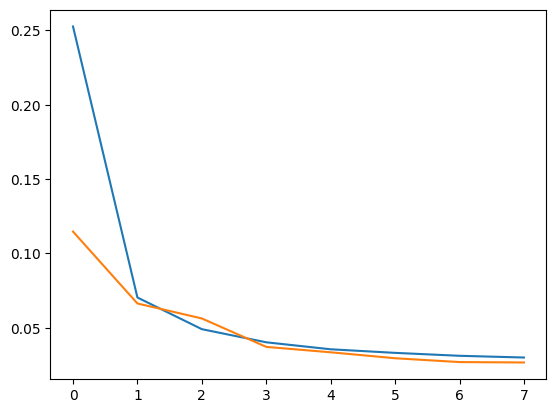

In [14]:
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

learning_rate = 0.0005
epochs = 8
loss = 'mse'
batch_size = 128
model.compile(loss=loss, optimizer=Adam(learning_rate = learning_rate), metrics=[RootMeanSquaredError()])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=False)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [15]:
# scale and get mae
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_final = scaler.inverse_transform(y_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(f'MAE: {round(mean_absolute_error(y_test_final, y_pred), 2)}')
print(f'RMSE: {round(sqrt(mean_squared_error(y_test_final, y_pred)), 2)}')

29/29 [==============================] - 1s 4ms/step
MAE: 0.63
RMSE: 0.82


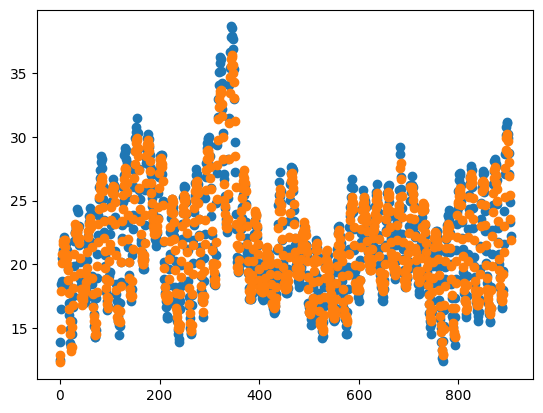

In [16]:
plt.scatter(x=[i for i in range(len(y_pred))], y=y_test_final.reshape(len(y_test_final),) )
plt.scatter(x=[i for i in range(len(y_pred))], y=y_pred.reshape(len(y_pred),) )

In [17]:
# model.save('cf_cl.h5')
# model.save('cf_cl.keras')
# # loaded_model = tf.keras.models.load_model('heath.h5')
# loaded_model = tf.keras.models.load_model('cf_cl.keras')
# loaded_model